In [29]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from scipy.ndimage import gaussian_filter


from google.protobuf import text_format
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from art.attacks.evasion import PixelAttack
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
from onePixelAttack import loadAttackData
from counter_adversarial import plot_image_grid

# Resnet

In [3]:
EPOCHS = 1
BATCH_SIZE = 64
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                              include_top=False,
                                                              weights='imagenet')(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy']) 
  return model

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)
resnet = define_compile_model()
resnet = tf.keras.models.load_model('./trainedModel')


In [5]:
# Some statistics I used in a previous ML class
def analysis(model, X, Y, classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']):
    ypred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(Y, ypred)
    cr = classification_report(Y, ypred)
    print('Test Statistics:', cr, sep='\n', end='\n\n\n')

    print('Confusion Matrix:')
    sns.heatmap(cm, linewidth=0.5, annot=cm, xticklabels=classes, yticklabels=classes)
    plt.show()

# Get image datasets

In [45]:
X_attacked, X_unattacked, y = loadAttackData('attacked.imgs')
X_attacked = np.asarray(X_attacked) / 255   # Scale RGB values between 0 and 1.0
X_unattacked = np.asarray(X_unattacked) / 255   # Scale RGB values between 0 and 1.0
X_attacked_test = X_attacked[0:int(len(X_attacked)/3)]
X_attacked_train = X_attacked[int(len(X_attacked)/3):]
X_unattacked_test = X_unattacked[0:int(len(X_unattacked)/3)]
X_unattacked_train = X_unattacked[int(len(X_unattacked)/3):]
y_test = np.asarray(y[0:int(len(y)/3)])
y_train = np.asarray(y[int(len(y)/3):])

# Analyze Resnet model with unattacked images

30/30 [==============================] - 46s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.59      0.97      0.73        98
           1       0.96      0.85      0.90       106
           2       0.82      0.83      0.83        94
           3       0.61      0.80      0.69        87
           4       0.87      0.81      0.84        94
           5       0.96      0.59      0.73        79
           6       0.97      0.73      0.84       104
           7       0.80      0.91      0.85        96
           8       0.93      0.78      0.85        95
           9       0.95      0.80      0.87       100

    accuracy                           0.81       953
   macro avg       0.85      0.81      0.81       953
weighted avg       0.85      0.81      0.82       953



Confusion Matrix:


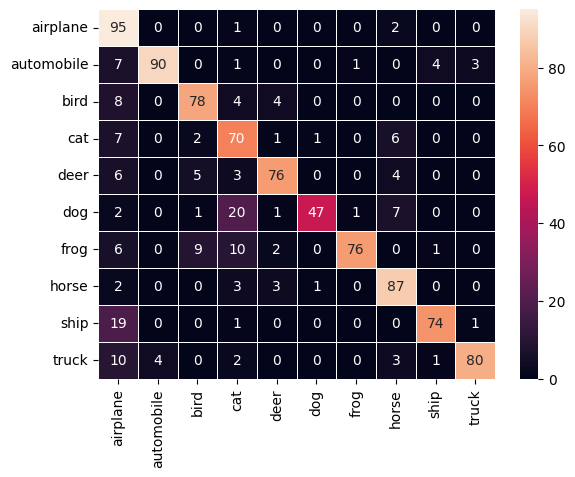

In [14]:
analysis(resnet, X_unattacked_test*255, y_test)

# Analyze Resnet with Attacked Images

30/30 [==============================] - 48s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.29      0.84      0.43        98
           1       0.82      0.69      0.75       106
           2       0.31      0.52      0.39        94
           3       0.32      0.46      0.38        87
           4       0.58      0.12      0.19        94
           5       0.53      0.30      0.39        79
           6       0.91      0.20      0.33       104
           7       0.61      0.40      0.48        96
           8       0.58      0.47      0.52        95
           9       0.79      0.54      0.64       100

    accuracy                           0.46       953
   macro avg       0.58      0.45      0.45       953
weighted avg       0.58      0.46      0.46       953



Confusion Matrix:


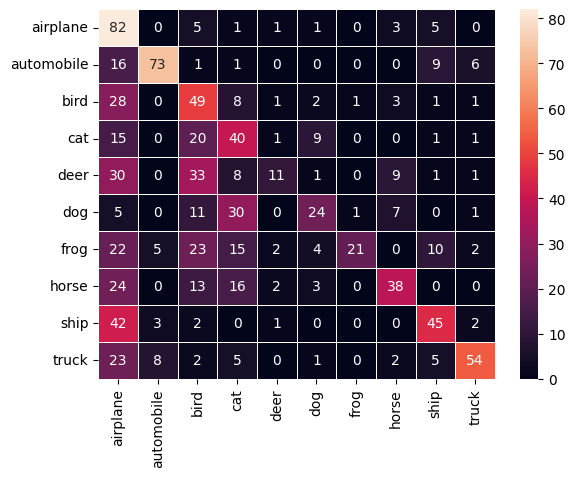

In [8]:
analysis(resnet, X_attacked_test*255, y_test)

# Training Code for counter adversarial models (if needed)

In [47]:
def create_fully_conv_denoising_autoencoder(input_shape, should_log = False):

    model = Sequential()

    model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu', input_shape = input_shape))
    model.add(layers.BatchNormalization()) # H, W, 16
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding='same', activation = 'relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    model.add(layers.BatchNormalization()) # H/2, W/2, 32
    model.add(layers.Conv2DTranspose(32, kernel_size = 3, activation="relu", strides=2, padding="same"))
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    model.add(layers.BatchNormalization()) # H, W, 16
    model.add(layers.Conv2D(filters = input_shape[2], kernel_size = 1, strides = 1, padding='same', activation = 'sigmoid'))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 500, decay_rate = 0.5)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

    if should_log:
        model.summary()

    return model


''' Create denoising autoencoder model that uses fully connected layers '''
def create_fully_conn_denoising_autoencoder(input_shape, should_log = False):

    model = Sequential()

    input_size = 1
    for val in input_shape:
        input_size *= val

    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 128, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units = input_size, activation = 'sigmoid'))
    model.add(layers.Reshape(input_shape))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001, decay_steps = 1000, decay_rate = 0.5)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

    if should_log:
        model.summary()

    return model


''' Create generative adversarial denoising autoencoder model that uses fully convolutional layers in the
autoencoder followed by a discriminator that also uses convolutional layers '''
def create_GAN_denoising_autoencoder(input_shape, should_log = False):

    autoencoder = Sequential()
    autoencoder.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu', input_shape = input_shape))
    autoencoder.add(layers.BatchNormalization()) # H, W, 16
    autoencoder.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding='same', activation = 'relu'))
    autoencoder.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    autoencoder.add(layers.BatchNormalization()) # H/2, W/2, 32
    autoencoder.add(layers.Conv2DTranspose(32, kernel_size = 3, activation="relu", strides=2, padding="same"))
    autoencoder.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    autoencoder.add(layers.BatchNormalization()) # H, W, 16
    autoencoder.add(layers.Conv2D(filters = input_shape[2], kernel_size = 1, strides = 1, padding='same', activation = 'sigmoid'))

    if should_log:
        autoencoder.summary()

    discriminator = Sequential()
    discriminator.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = layers.LeakyReLU(), input_shape = input_shape))
    discriminator.add(layers.BatchNormalization()) # H, W, 16
    discriminator.add(layers.Dropout(0.5))
    discriminator.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding='same', activation = layers.LeakyReLU()))
    discriminator.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation = layers.LeakyReLU()))
    discriminator.add(layers.BatchNormalization()) # H/2, W/2, 32
    discriminator.add(layers.Dropout(0.5))
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(units = 1, activation = 'sigmoid'))

    if should_log:
        discriminator.summary()

    return autoencoder, discriminator


''' Function used to calculate loss values for generative adversarial denoising autoencoder model '''
def get_GAN_denoising_autoencoder_losses(unattacked_images, denoised_images, denoised_disc_output, unattacked_disc_output, mse, binary_cross_entropy):

    # Calculate autoencoder loss (sum of MSE and binary cross entropy from discriminator being fooled
    # into thinking denoised images are unattacked)
    mse_autoencoder_loss = mse(unattacked_images, denoised_images)
    discriminator_output_loss = binary_cross_entropy(tf.ones_like(denoised_disc_output), denoised_disc_output)
    autoencoder_loss = 75 * mse_autoencoder_loss + discriminator_output_loss

    # Calculate discriminator loss (sum of binary cross entropy from correctly classifying unattacked
    # images as unattacked and from correctly classifying denoised images as denoised)
    unattacked_discriminator_loss = binary_cross_entropy(tf.ones_like(unattacked_disc_output), unattacked_disc_output)
    denoised_discriminator_loss = binary_cross_entropy(tf.zeros_like(denoised_disc_output), denoised_disc_output)
    discriminator_loss = unattacked_discriminator_loss + denoised_discriminator_loss

    return autoencoder_loss, discriminator_loss


''' Function used by TensorFlow to train the generative adversarial denoising autoencoder for a single step;
credit: https://www.tensorflow.org/tutorials/generative/dcgan '''
@tf.function
def train_GAN_denoising_autoencoder_step(attacked_images, unattacked_images, autoencoder, discriminator, mse, binary_cross_entropy, autoencoder_optimizer, discriminator_optimizer):

    # Perform training step
    with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as discriminator_tape:
        denoised_images = autoencoder(attacked_images, training=True)

        denoised_disc_output = discriminator(denoised_images, training=True)
        unattacked_disc_output = discriminator(unattacked_images, training=True)

        autoencoder_loss, discriminator_loss = get_GAN_denoising_autoencoder_losses(unattacked_images, denoised_images, denoised_disc_output, unattacked_disc_output, mse, binary_cross_entropy)

    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    gradients_of_autoencoder = autoencoder_tape.gradient(autoencoder_loss, autoencoder.trainable_variables)
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))


''' Function used to train generative adversarial denoising autoencoder model;
credit: https://www.tensorflow.org/tutorials/generative/dcgan '''
def train_GAN_denoising_autoencoder(attacked_images_train, unattacked_images_train, attacked_images_val, unattacked_images_val, num_epochs, batch_size, autoencoder, discriminator):

    # Init loss functions from Keras
    mse = keras.losses.MeanSquaredError()
    binary_cross_entropy = keras.losses.BinaryCrossentropy()

    # Init Adam optimizers for both autoencoder and generator
    autoencoder_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    # Calculate number of batches per epoch
    num_batches_per_epoch = int(attacked_images_train.shape[0] / batch_size)

    # Train for given number of epochs
    autoencoder_losses_train = []
    discriminator_losses_train = []
    autoencoder_losses_val = []
    discriminator_losses_val = []
    for epoch in range(num_epochs):

        print('Starting epoch ' + str(epoch+1) + '/' + str(num_epochs))
        
        # Train one step for each batch in a single epoch
        for _ in range(num_batches_per_epoch):

            # Randomly select batch of batch_size samples from training data
            batch_rand_img_inds = np.random.randint(0, attacked_images_train.shape[0], batch_size)
            attacked_images_batch = attacked_images_train[batch_rand_img_inds]
            unattacked_images_batch = unattacked_images_train[batch_rand_img_inds]

            # Perform training step on current batch of attacked and unattacked images
            train_GAN_denoising_autoencoder_step(attacked_images_batch, unattacked_images_batch, autoencoder, discriminator, mse, binary_cross_entropy, autoencoder_optimizer, discriminator_optimizer)
            
        # Calculate and print losses for the epoch for all training data
        denoised_images_train = autoencoder(attacked_images_train, training = False)
        denoised_disc_output_train = discriminator(denoised_images_train, training = False)
        unattacked_disc_output_train = discriminator(unattacked_images_train, training = False)
        autoencoder_loss_train, discriminator_loss_train = get_GAN_denoising_autoencoder_losses(unattacked_images_train, denoised_images_train, denoised_disc_output_train, unattacked_disc_output_train, mse, binary_cross_entropy)

        print('    autoencoder_loss_train: ' + str(float(autoencoder_loss_train)) + ' - discriminator_loss_train: ' + str(float(discriminator_loss_train)))
        autoencoder_losses_train.append(autoencoder_loss_train)
        discriminator_losses_train.append(discriminator_loss_train)

        # Calculate and print losses for the epoch for all validation data
        denoised_images_val = autoencoder(attacked_images_val, training = False)
        denoised_disc_output_val = discriminator(denoised_images_val, training = False)
        unattacked_disc_output_val = discriminator(unattacked_images_val, training = False)
        autoencoder_loss_val, discriminator_loss_val = get_GAN_denoising_autoencoder_losses(unattacked_images_val, denoised_images_val, denoised_disc_output_val, unattacked_disc_output_val, mse, binary_cross_entropy)

        print('    autoencoder_loss_val: ' + str(float(autoencoder_loss_val)) + ' - discriminator_loss_val: ' + str(float(discriminator_loss_val)))
        autoencoder_losses_val.append(autoencoder_loss_val)
        discriminator_losses_val.append(discriminator_loss_val)
    
    return autoencoder_losses_train, discriminator_losses_train, autoencoder_losses_val, discriminator_losses_val


In [48]:
# num_epochs = 1000
# conv = create_fully_conv_denoising_autoencoder(X_attacked[0].shape)
# conv.fit(X_attacked_train, X_unattacked_train, epochs = num_epochs, batch_size = 256, shuffle = True, validation_data = (X_attacked_test, X_unattacked_test))
# conv.save('./trained_fully_conv')

# num_epochs = 10000
# connect = create_fully_conn_denoising_autoencoder(X_attacked[0].shape)
# connect.fit(X_attacked_train, X_unattacked_train, epochs = num_epochs, batch_size = 256, shuffle = True, validation_data = (X_attacked_test, X_unattacked_test))
# connect.save('./trained_fully_con')

num_epochs = 1000
autoencoder, discriminator = create_GAN_denoising_autoencoder(X_attacked[0].shape)
autoencoder_losses_train, discriminator_losses_train, autoencoder_losses_val, discriminator_losses_val = train_GAN_denoising_autoencoder(X_attacked_train, X_unattacked_train, X_attacked_test, X_unattacked_test, num_epochs, 256, autoencoder, discriminator)
gan = autoencoder
gan.save('./trained_gan')

Starting epoch 1/1000
    autoencoder_loss_train: 5.399355888366699 - discriminator_loss_train: 1.3878486156463623
    autoencoder_loss_val: 5.426000595092773 - discriminator_loss_val: 1.3873934745788574
Starting epoch 2/1000
    autoencoder_loss_train: 5.493997097015381 - discriminator_loss_train: 1.3729300498962402
    autoencoder_loss_val: 5.520807266235352 - discriminator_loss_val: 1.3717734813690186
Starting epoch 3/1000
    autoencoder_loss_train: 5.553037643432617 - discriminator_loss_train: 1.3667649030685425
    autoencoder_loss_val: 5.5799880027771 - discriminator_loss_val: 1.3648338317871094
Starting epoch 4/1000
    autoencoder_loss_train: 5.58857536315918 - discriminator_loss_train: 1.3616864681243896
    autoencoder_loss_val: 5.6156768798828125 - discriminator_loss_val: 1.359209418296814
Starting epoch 5/1000
    autoencoder_loss_train: 5.6005048751831055 - discriminator_loss_train: 1.3565226793289185
    autoencoder_loss_val: 5.62779426574707 - discriminator_loss_val: 1.

INFO:tensorflow:Assets written to: ./trained_gan\assets


INFO:tensorflow:Assets written to: ./trained_gan\assets


# Fully Convolutional Autoencoder

## Attacked

30/30 [==============================] - 46s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        98
           1       0.96      0.72      0.82       106
           2       0.64      0.68      0.66        94
           3       0.51      0.70      0.59        87
           4       0.81      0.63      0.71        94
           5       0.82      0.52      0.64        79
           6       0.93      0.63      0.75       104
           7       0.74      0.84      0.79        96
           8       0.78      0.73      0.75        95
           9       0.89      0.68      0.77       100

    accuracy                           0.71       953
   macro avg       0.76      0.70      0.71       953
weighted avg       0.76      0.71      0.71       953



Confusion Matrix:


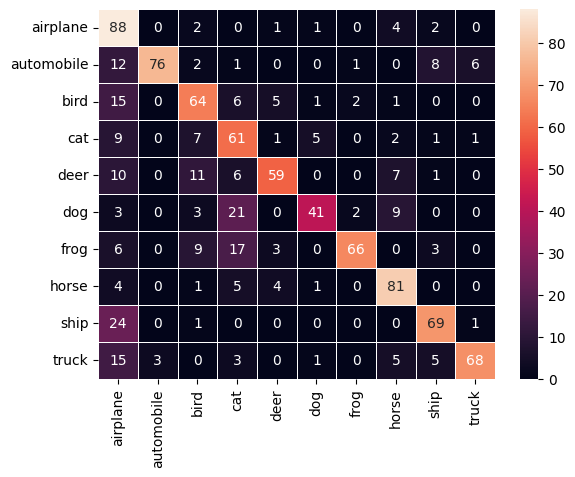

Images count:  9


<Figure size 640x480 with 0 Axes>

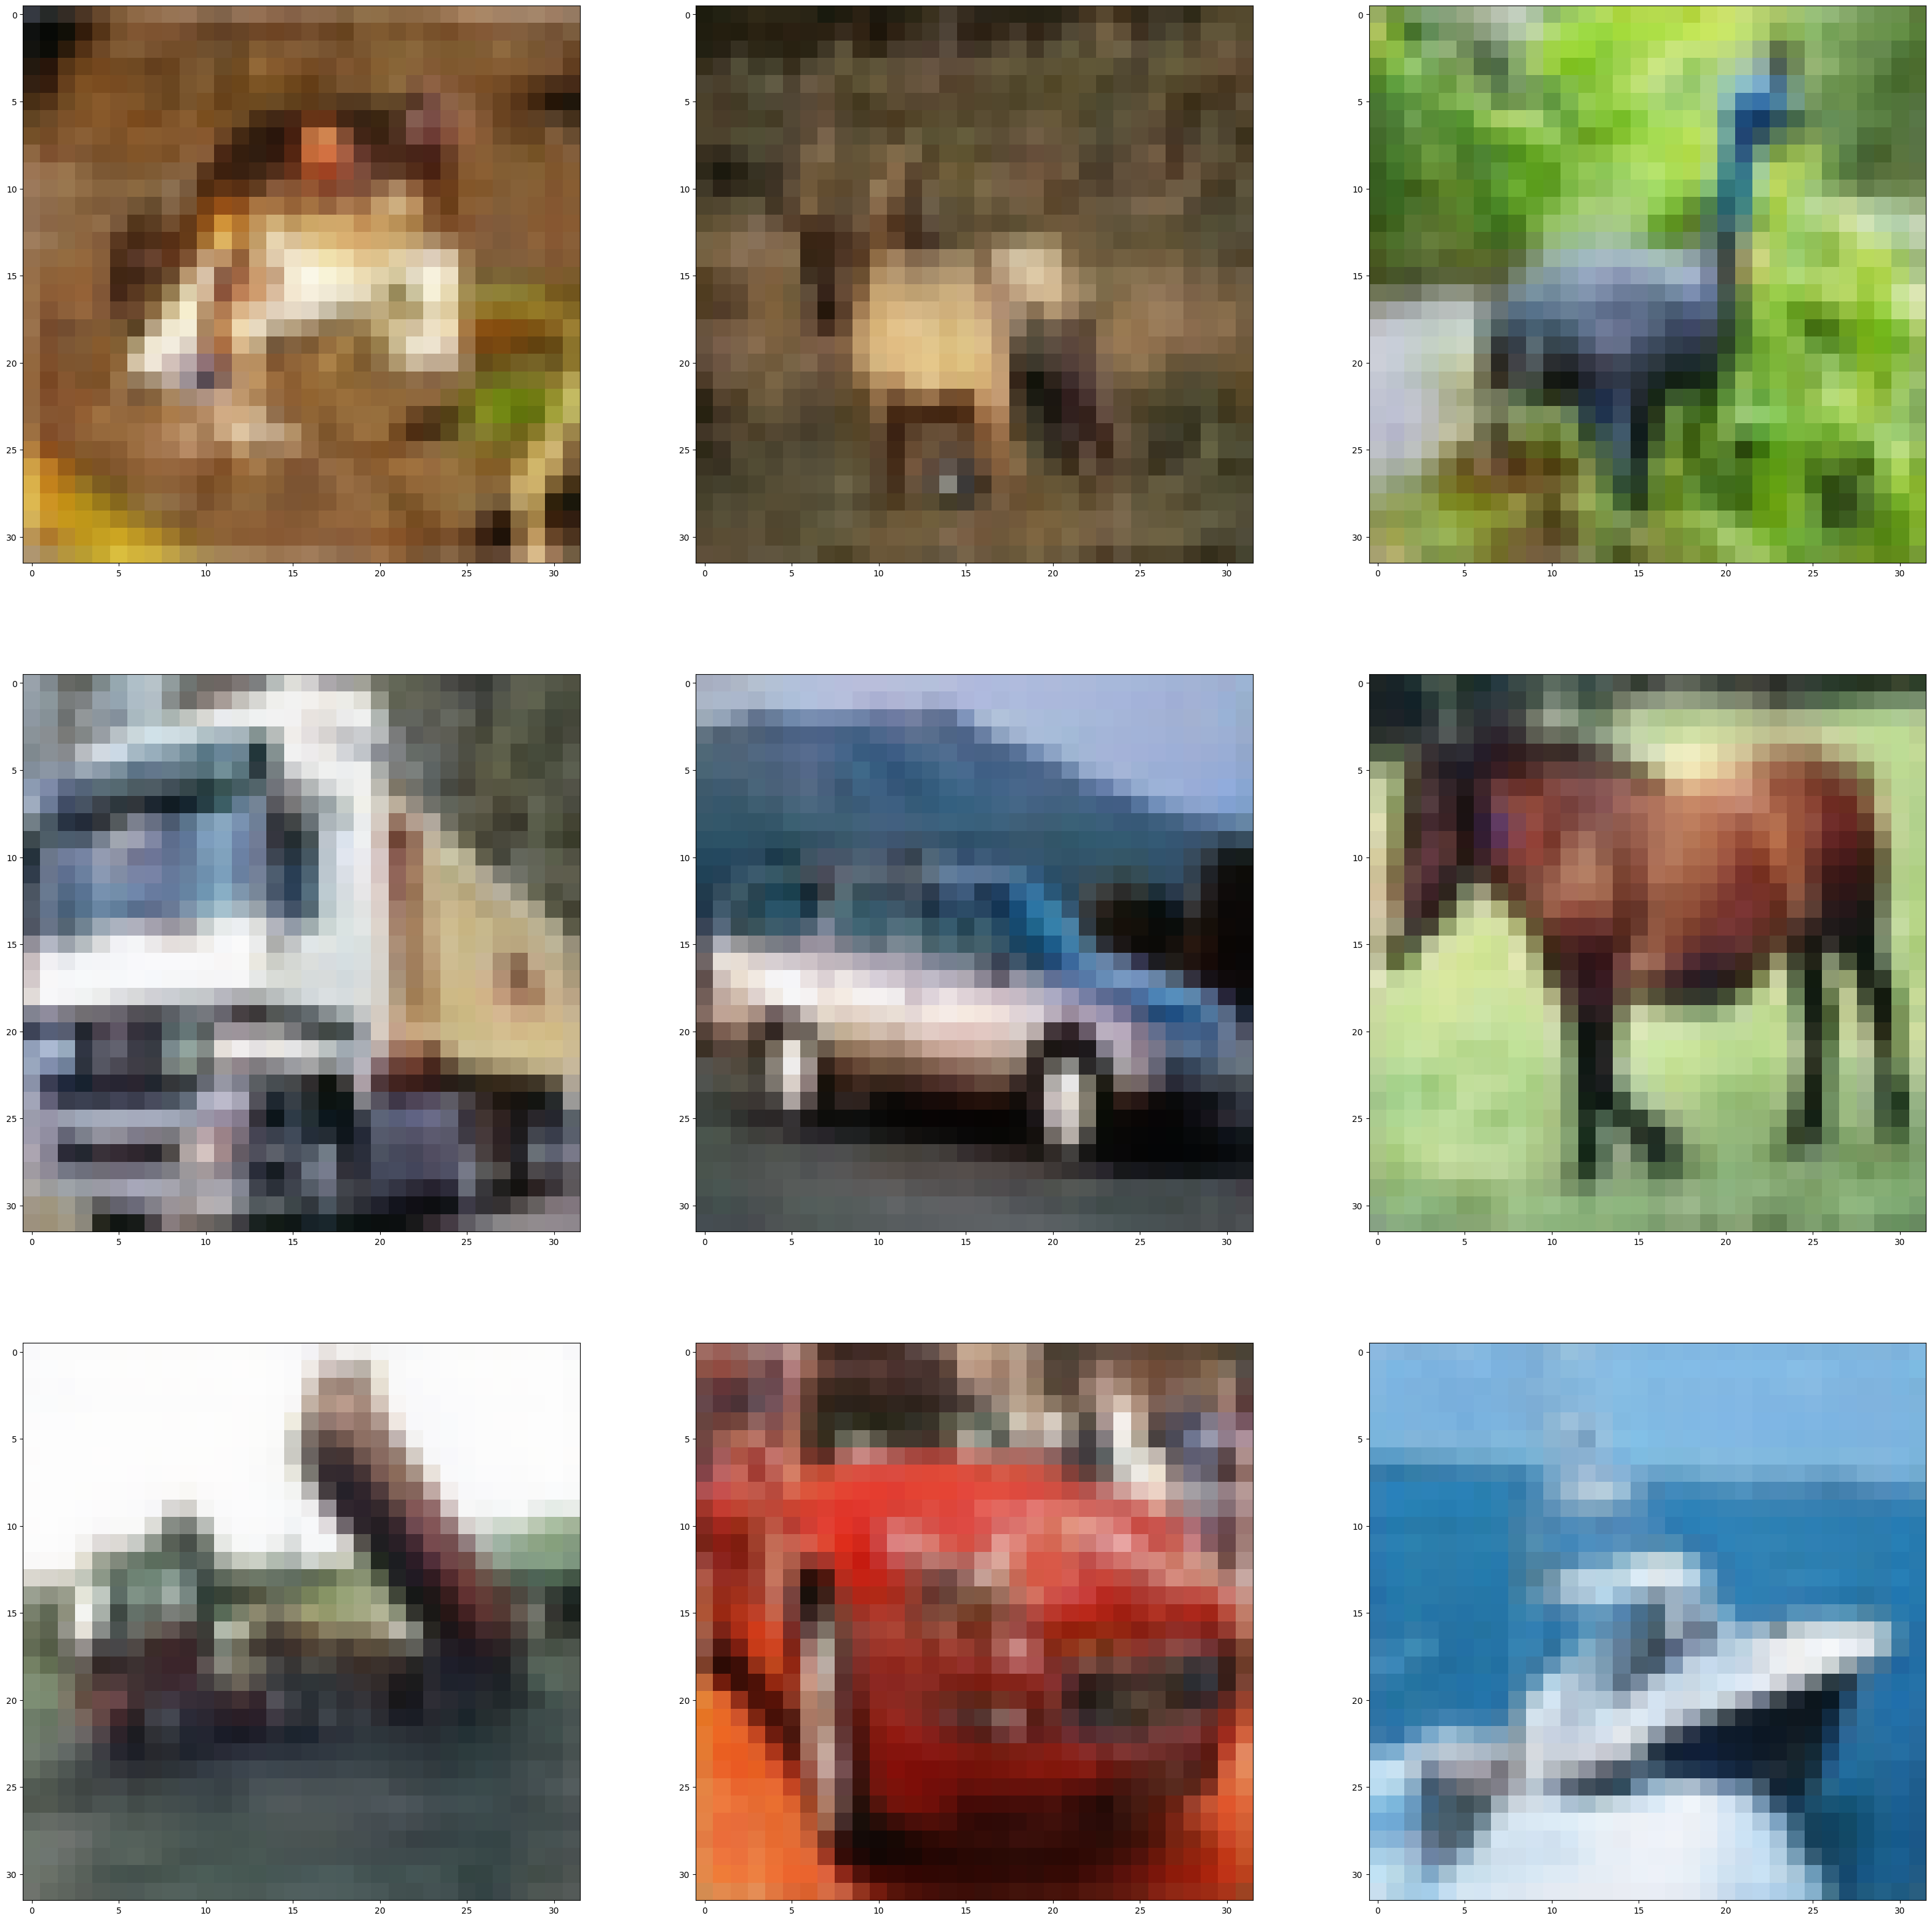

In [42]:
conv = tf.keras.models.load_model('./trained_fully_conv')

a = conv.predict(X_attacked_test)
analysis(resnet, a*255, y_test)
plot_image_grid(a[:9] * 255, save_grid_filename='denoised_attacked_imgs_connect.png')


## Unattacked

30/30 [==============================] - 47s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.55      0.93      0.69        98
           1       0.97      0.80      0.88       106
           2       0.77      0.79      0.78        94
           3       0.58      0.77      0.66        87
           4       0.84      0.79      0.81        94
           5       0.94      0.56      0.70        79
           6       0.96      0.70      0.81       104
           7       0.77      0.91      0.83        96
           8       0.87      0.76      0.81        95
           9       0.93      0.74      0.82       100

    accuracy                           0.78       953
   macro avg       0.82      0.77      0.78       953
weighted avg       0.82      0.78      0.78       953



Confusion Matrix:


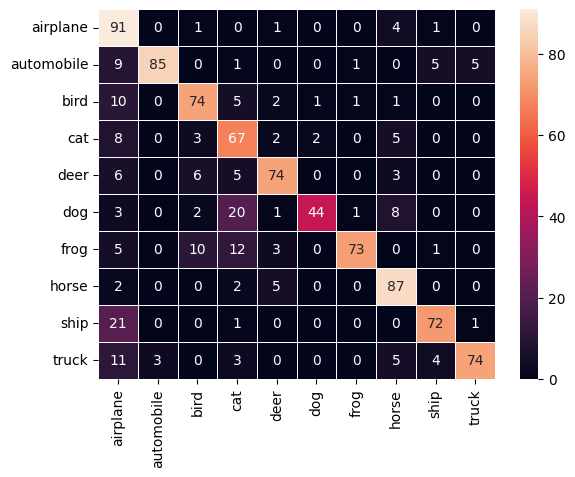

Images count:  9


<Figure size 640x480 with 0 Axes>

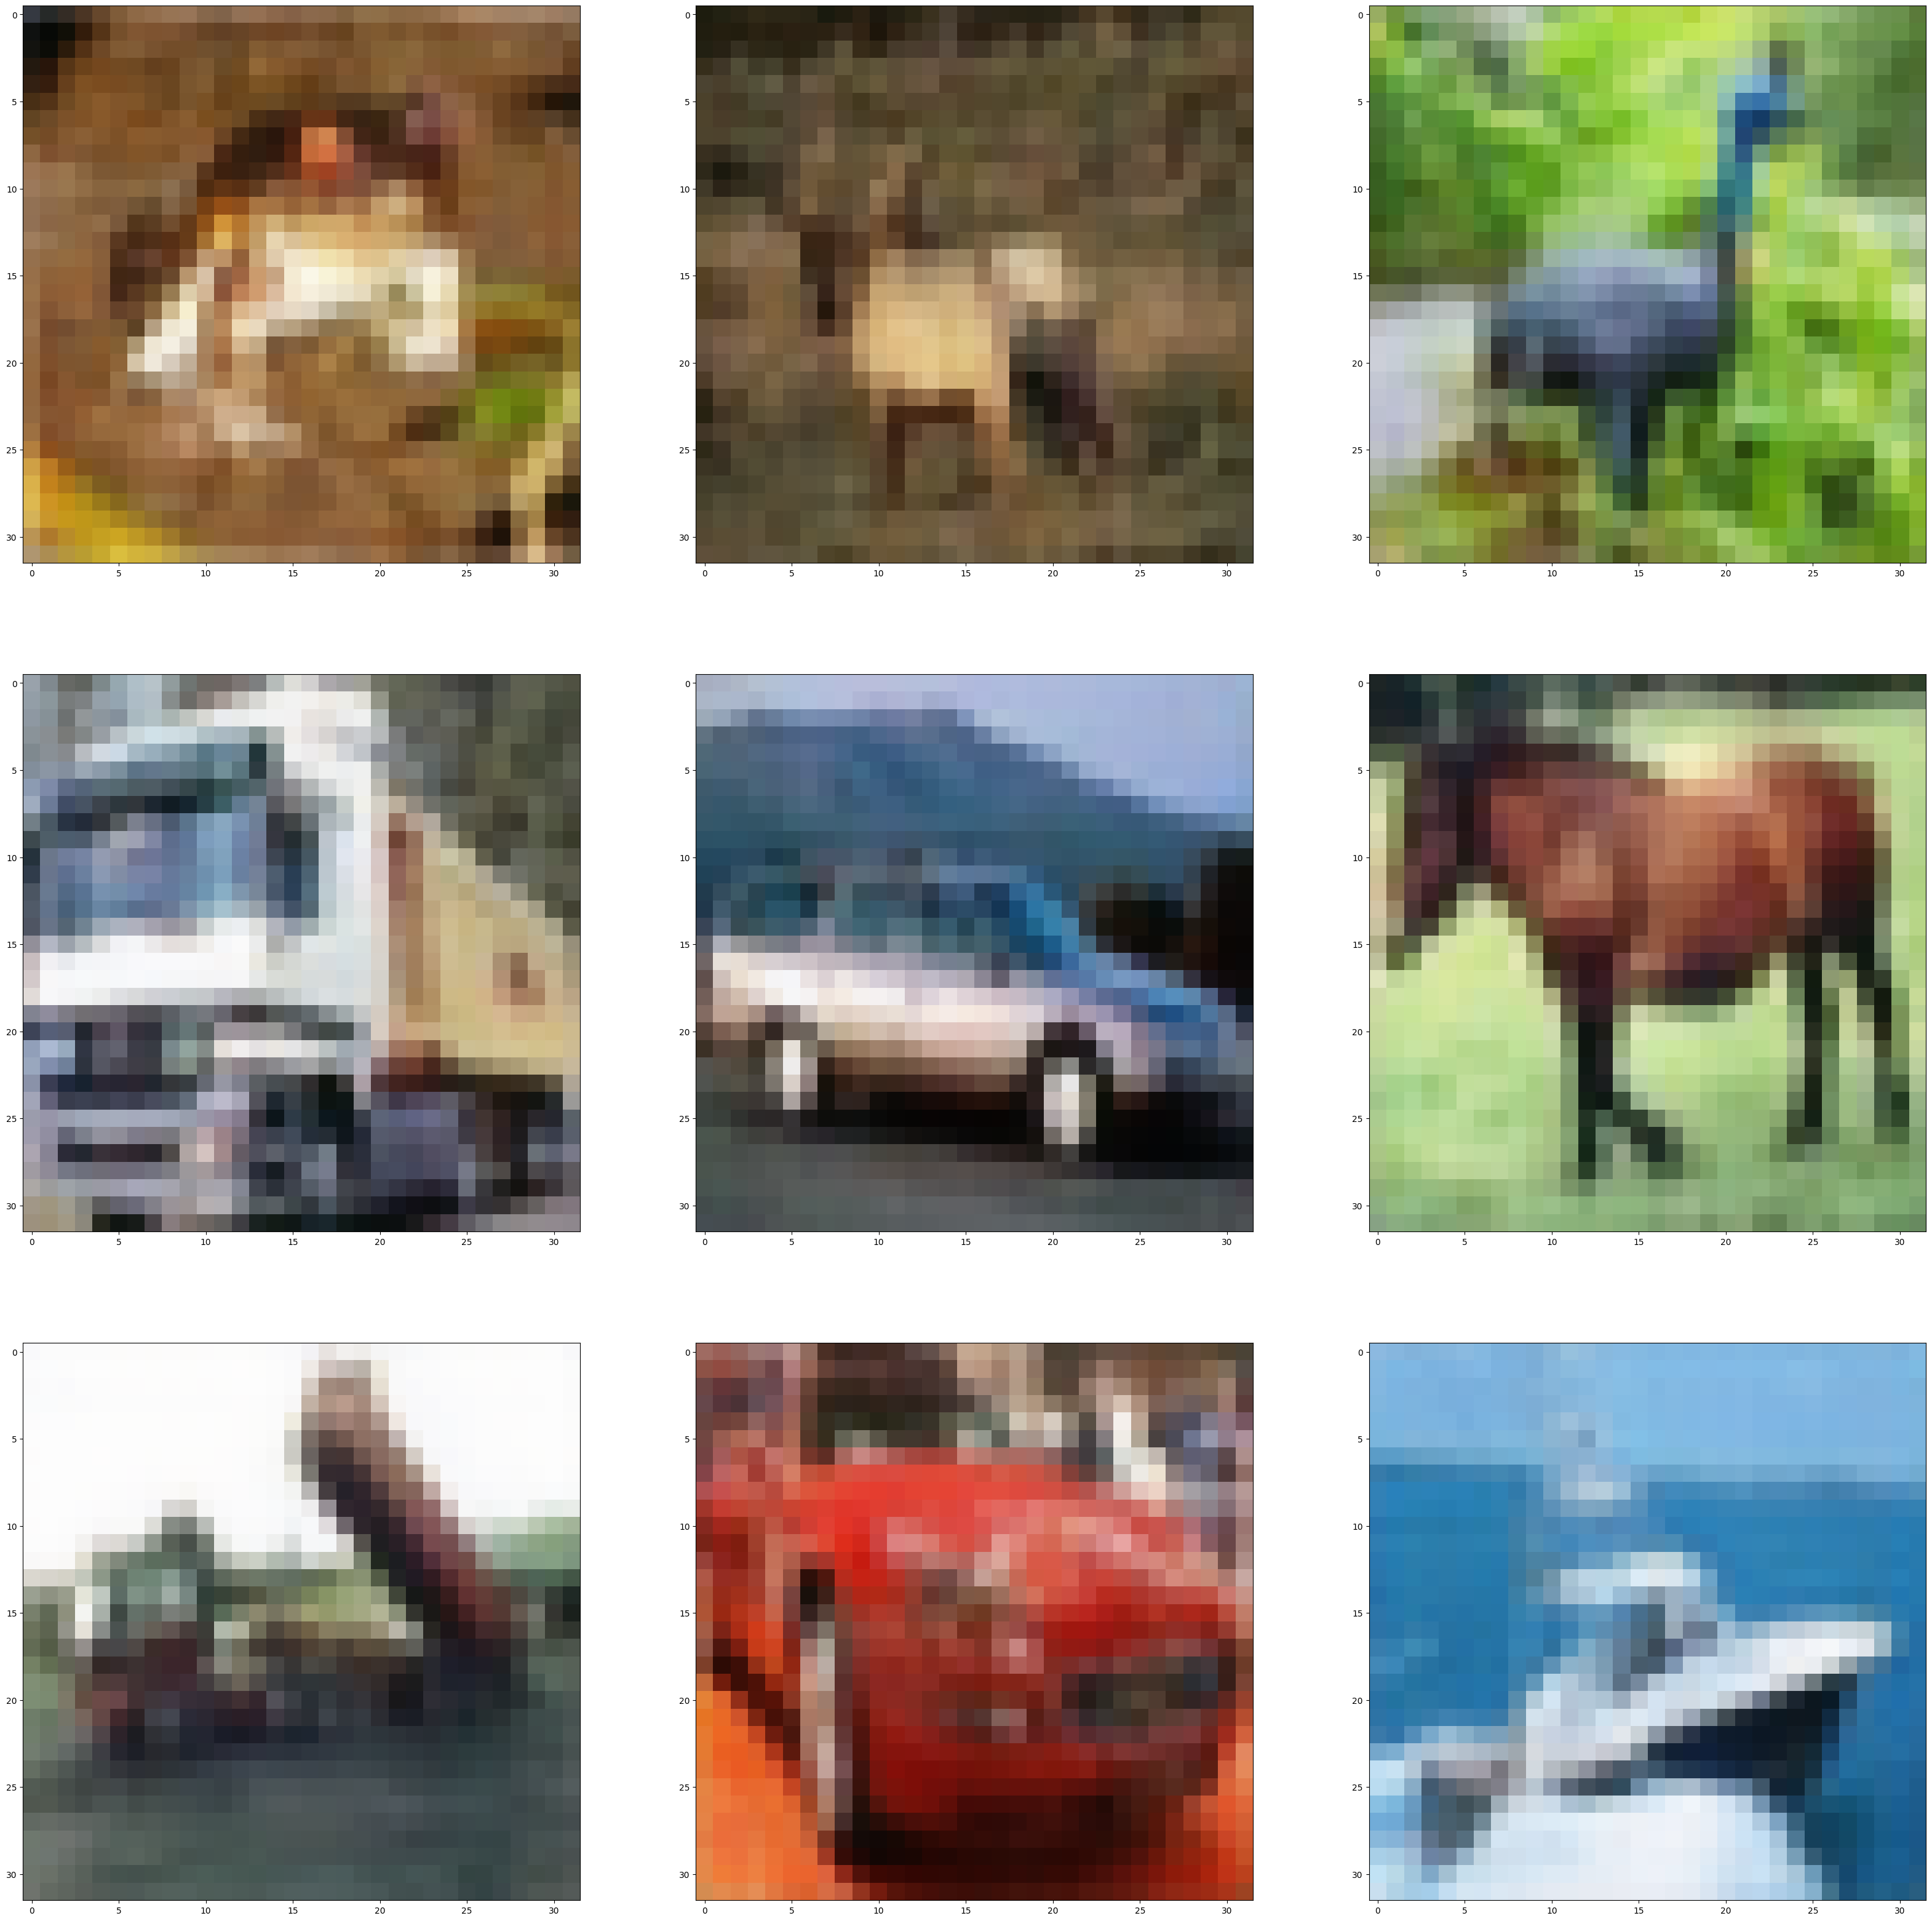

In [43]:
a = conv.predict(X_unattacked_test)
analysis(resnet, a*255, y_test)
plot_image_grid(a[:9] * 255, save_grid_filename='denoised_attacked_imgs_connect.png')


# Fully Connected Autoencoder

30/30 [==============================] - 45s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.11      0.91      0.19        98
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00        94
           3       0.12      0.08      0.10        87
           4       0.24      0.09      0.12        94
           5       0.00      0.00      0.00        79
           6       1.00      0.02      0.04       104
           7       0.14      0.03      0.05        96
           8       0.25      0.01      0.02        95
           9       0.00      0.00      0.00       100

    accuracy                           0.12       953
   macro avg       0.19      0.11      0.05       953
weighted avg       0.19      0.12      0.05       953



Confusion Matrix:


c:\Users\matth\OneDrive\Documents\notes\525\CS525_Projects\.venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matth\OneDrive\Documents\notes\525\CS525_Projects\.venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matth\OneDrive\Documents\notes\525\CS525_Projects\.venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

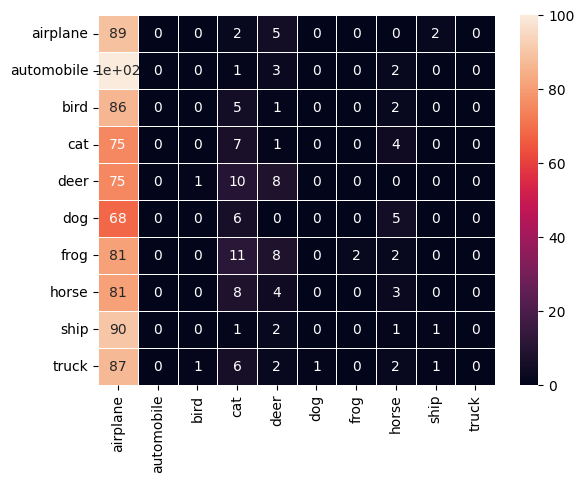

In [40]:
connect = tf.keras.models.load_model('./trained_fully_con')
a = connect.predict(X_attacked_test)
analysis(resnet, a*255, y_test)

Images count:  9


<Figure size 640x480 with 0 Axes>

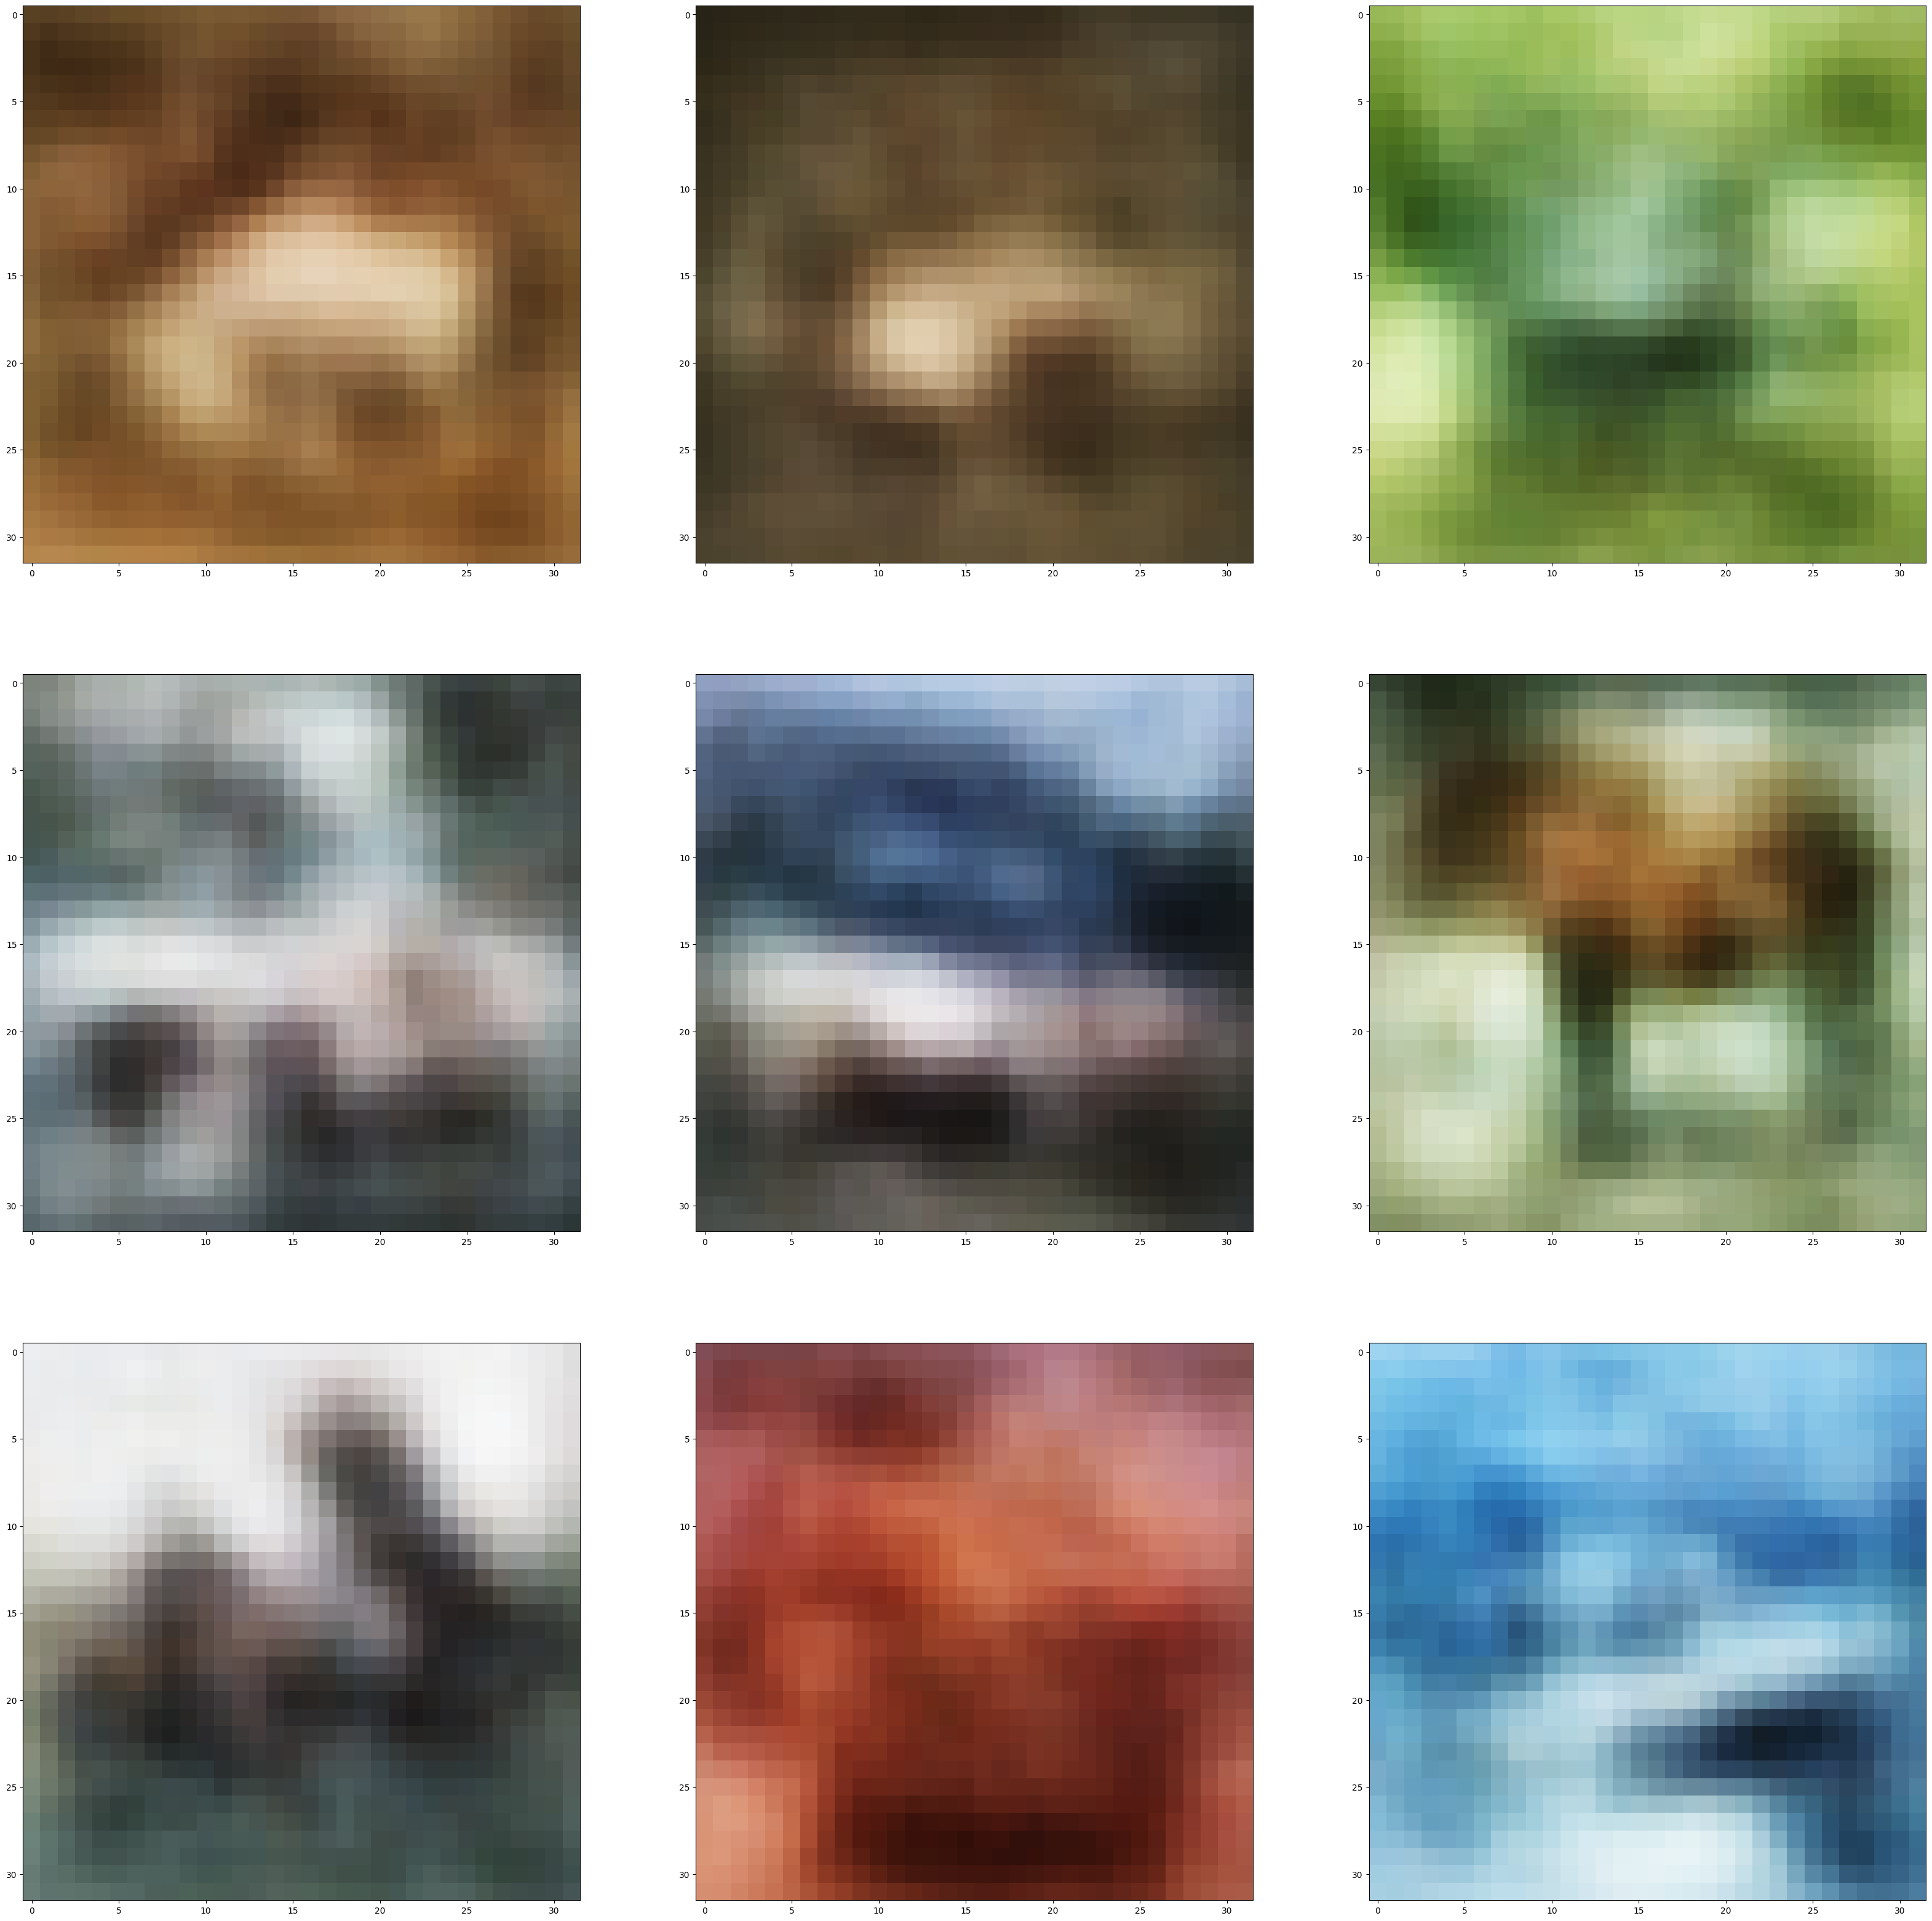

In [41]:
plot_image_grid(a[:9] * 255, save_grid_filename='denoised_attacked_imgs_connect.png')


# GAN

30/30 [==============================] - 47s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.46      0.72      0.56        98
           1       0.96      0.42      0.58       106
           2       0.58      0.57      0.58        94
           3       0.42      0.68      0.52        87
           4       0.60      0.67      0.63        94
           5       0.81      0.37      0.50        79
           6       0.72      0.67      0.70       104
           7       0.71      0.73      0.72        96
           8       0.53      0.66      0.59        95
           9       0.76      0.48      0.59       100

    accuracy                           0.60       953
   macro avg       0.65      0.60      0.60       953
weighted avg       0.66      0.60      0.60       953



Confusion Matrix:


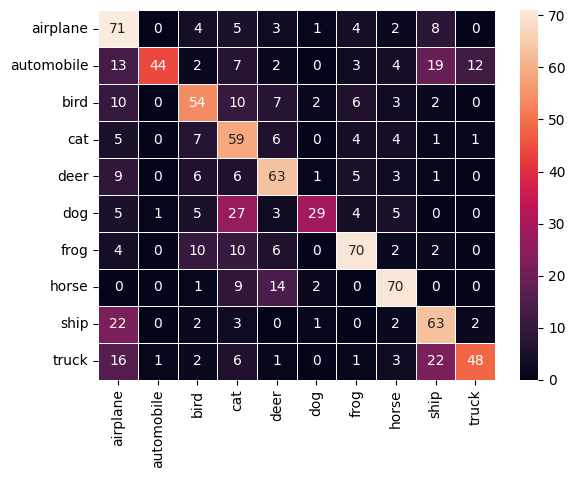

Images count:  9


<Figure size 640x480 with 0 Axes>

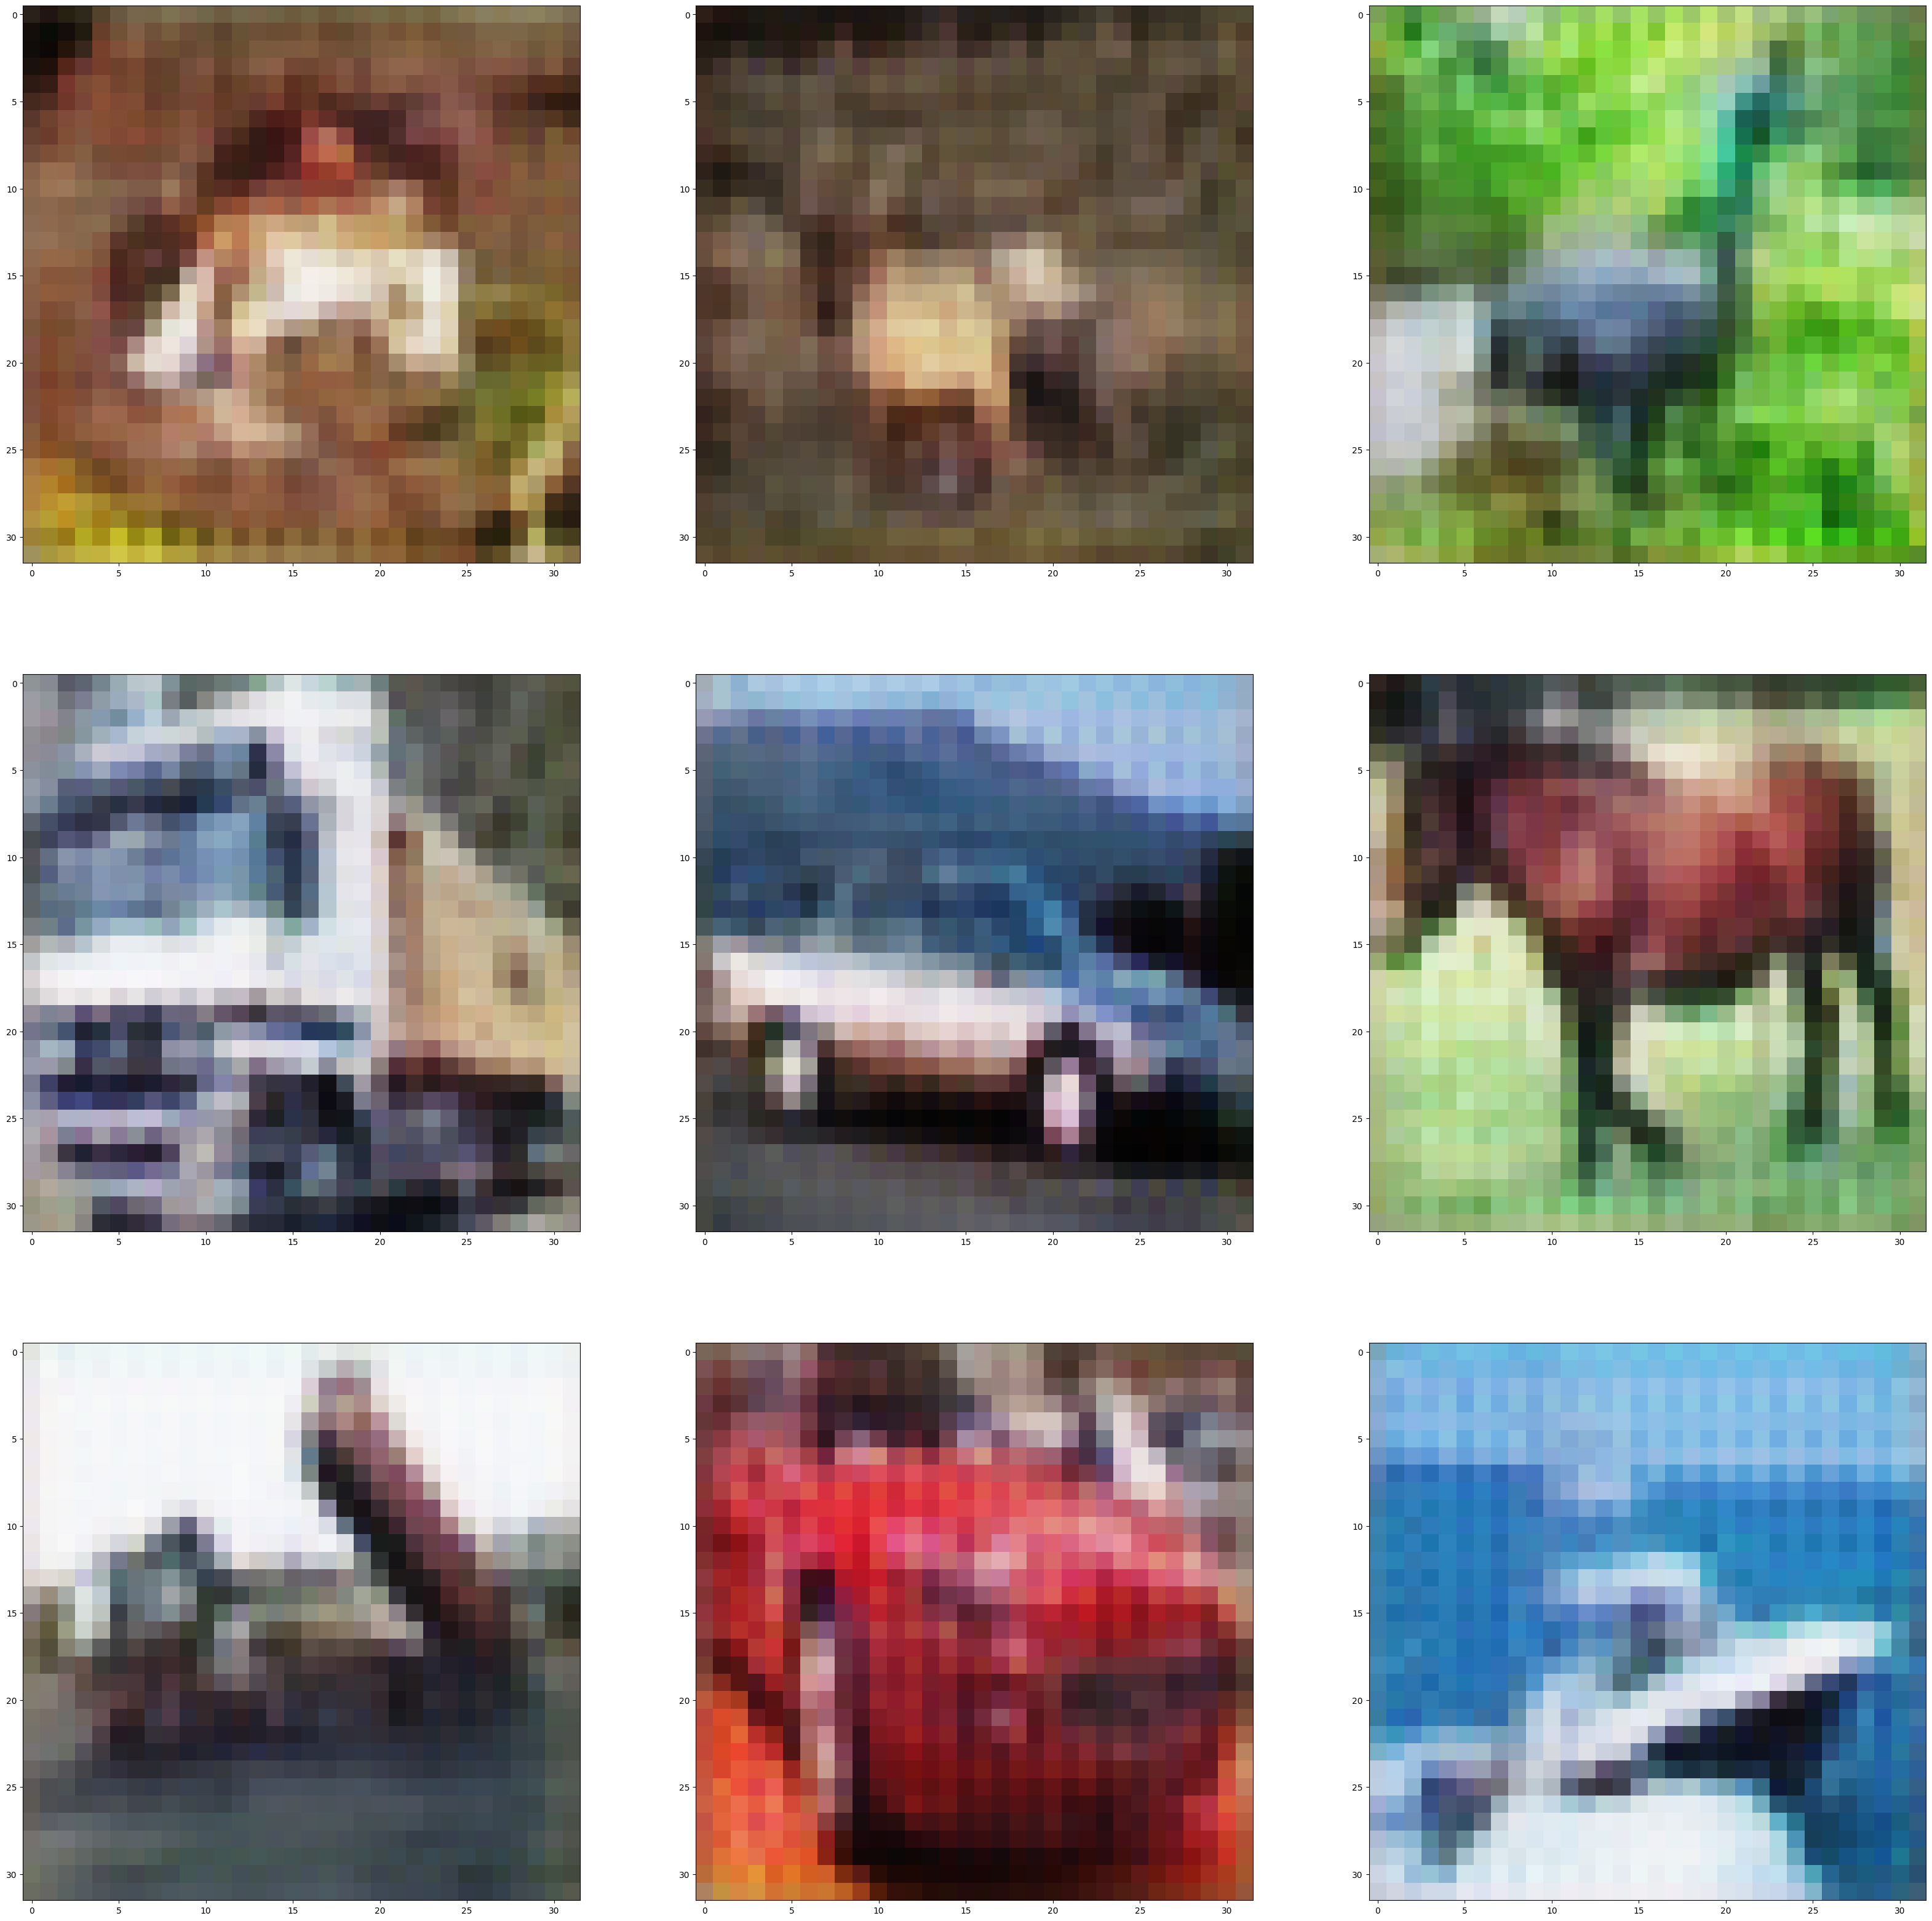

In [49]:
gan = tf.keras.models.load_model('./trained_gan')
a = gan.predict(X_attacked_test)
analysis(resnet, a*255, y_test)
plot_image_grid(a[:9] * 255, save_grid_filename='denoised_attacked_imgs_connect.png')


# Gaussian Blur for baseline

In [34]:
# Get images that are slightly Gaussian blurred for non-NN baseline
denoised_attacked_images = []
for attacked_image in X_attacked_test:
    denoised_attacked_images.append(gaussian_filter(attacked_image, sigma = 0.5))

denoised_unattacked_images = []
for unattacked_image in X_unattacked_test:
    denoised_unattacked_images.append(gaussian_filter(unattacked_image, sigma = 0.5))

denoised_attacked_images = np.asarray(denoised_attacked_images)
denoised_unattacked_images = np.asarray(denoised_unattacked_images)

30/30 [==============================] - 46s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.46      0.93      0.62        98
           1       0.97      0.74      0.84       106
           2       0.86      0.72      0.79        94
           3       0.49      0.78      0.60        87
           4       0.84      0.74      0.79        94
           5       0.95      0.53      0.68        79
           6       0.98      0.56      0.71       104
           7       0.77      0.89      0.83        96
           8       0.80      0.69      0.74        95
           9       0.92      0.73      0.82       100

    accuracy                           0.73       953
   macro avg       0.81      0.73      0.74       953
weighted avg       0.81      0.73      0.74       953



Confusion Matrix:


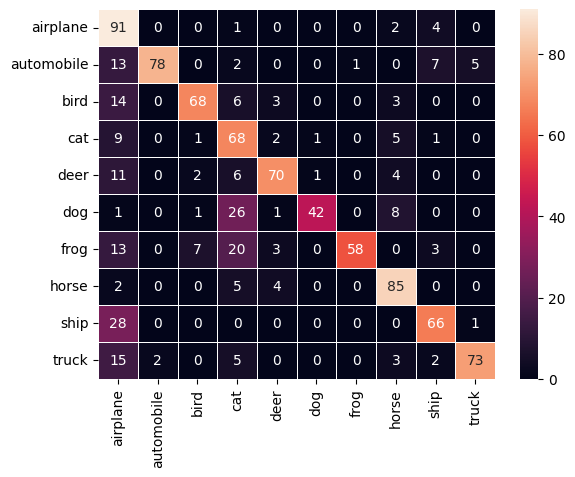

In [39]:
analysis(resnet, denoised_unattacked_images*255, y_test)

30/30 [==============================] - 46s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.33      0.90      0.48        98
           1       0.96      0.68      0.80       106
           2       0.44      0.54      0.49        94
           3       0.37      0.66      0.47        87
           4       0.77      0.32      0.45        94
           5       0.73      0.34      0.47        79
           6       1.00      0.28      0.44       104
           7       0.80      0.59      0.68        96
           8       0.66      0.60      0.63        95
           9       0.86      0.69      0.77       100

    accuracy                           0.56       953
   macro avg       0.69      0.56      0.57       953
weighted avg       0.70      0.56      0.57       953



Confusion Matrix:


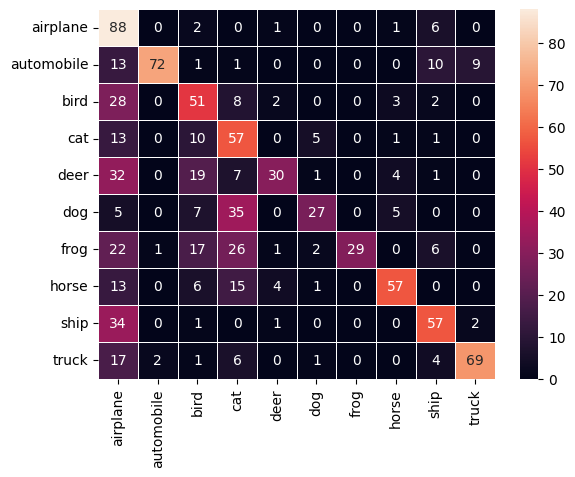

In [35]:
analysis(resnet, denoised_attacked_images*255, y_test)

Images count:  9


<Figure size 640x480 with 0 Axes>

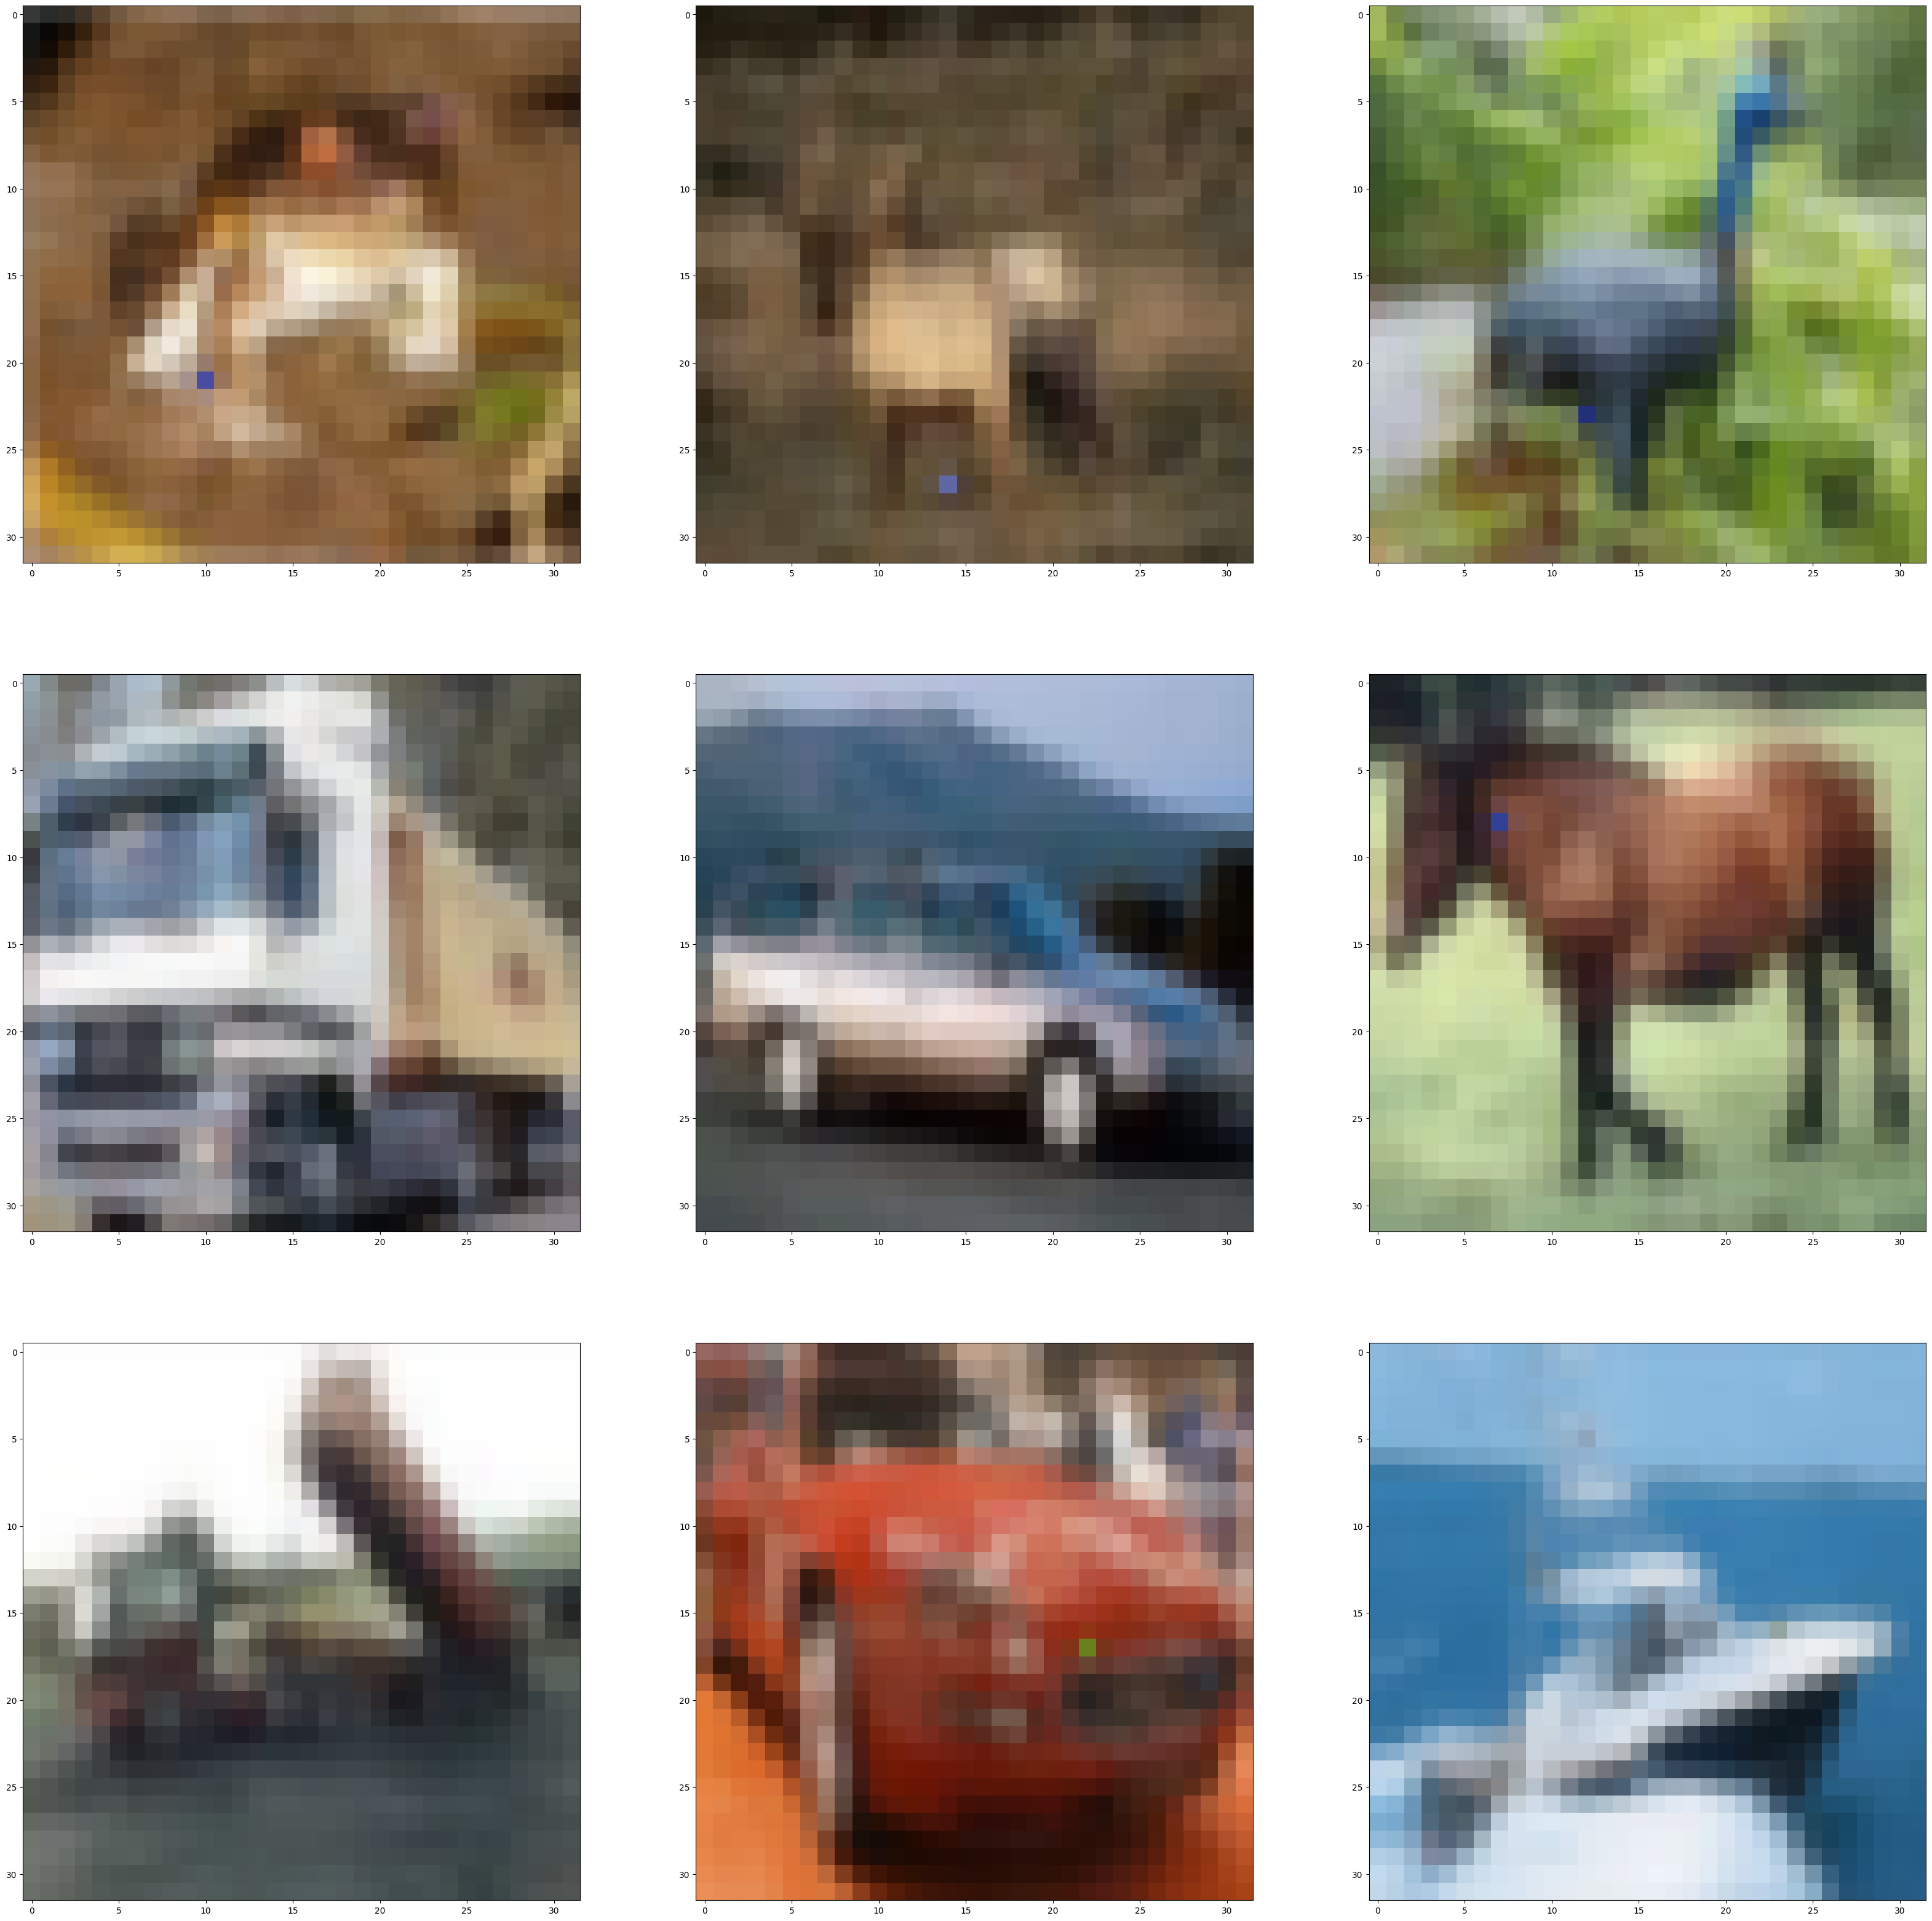

In [36]:
plot_image_grid(denoised_attacked_images[:9] * 255, save_grid_filename='denoised_attacked_imgs_gaussian.png')
